In [1]:
# Building a simple Neural Network for Handwritten Digit Recognition with the MNIST dataset from Kaggle
# Using Jupyter Notebook, Python 3, NumPy and Math

# https://www.kaggle.com/competitions/digit-recognizer/overview                      #data I used for training
# https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_test.csv    #data I used for testing 

# https://www.youtube.com/watch?v=w8yWXqWQYmU&t=1667s                                #video I used to understand the math and code
# Sidenote to the video: It explains every step very nicely, in a simple and compact way.
# Nevertheless I had some issues with the code (even after making sure I corrected the mentioned errors of the video)
# and spent hours on debugging it. 


# We start by importing NumPy, Matplotlib, and Pandas libraries to help us work with numbers,
# create visualizations like graphs, and manage data tables, respectively.

import numpy as np                  # NumPy for numerical operations
import matplotlib.pyplot as plt     # Matplotlib for plotting graphs
import pandas as pd                 # Pandas for handling data tables

In [2]:
# We use Pandas to read the data from a CSV file (in this case previously downloaded from Kaggle) located at the specified path.
data = pd.read_csv(r"C:\Users\Home\Documents\STUDIUM\train.csv")

In [3]:
# the ".head" command displays the first 5 rows of the loaded data to inspect its structure
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Panda DataFrame gets converted into a NumPy Array (from original tabular data structure) so we can do algebra with it
data = np.array(data)

# m = represents number of rows in the data array; specifically m = number of samples in the dataset
# n = represents number of columns; n= number of features plus one (including the label column)
m, n = data.shape

# shuffels the rows of the data array randomly; to ensure that the data is randomly ordered before splitting it into training and validation sets,
# helps prevent any unintentional ordering biases in the data and eliminates the risk of overfitting to the actual data
np.random.shuffle(data)


# selects a portion of the shuffled data (from index 1000 to the end) to be used as the development set (or validation set)
# the ".T" at the end transposes the array, swapping rows and columns
data_dev = data[1000:, :].T

# These lines extract the labels (Y_dev) and the features (X_dev) from the development set:
# Y_dev is assumed to be the first column of the data_dev array
# X_dev contains all other columns (features)
Y_dev = data_dev[0]
X_dev = data_dev[1:]

# Following step divides each pixel value in the feature matrix X_dev by 255. 
# This makes sure all pixel values are between 0 and 1, which is helpful for processing images. (common preprocessing step for image data)
X_dev = X_dev / 255.


###############################################################################################################################################


# selects the remaining portion of the shuffled data (excluding the validation set) to be used as the training set
data_train = data[:1000].T


# These lines extract the labels (Y_train) and the features (X_train) from the training set again:
# Y_train is assumed to be the first column of the data_train array
# X_train contains all other columns (features)
Y_train = data_train[0]
X_train = data_train[1:]


# normalizes the pixel values in the feature matrix X_train (=> devides X_train by 255)
X_train = X_train / 255.


# Reshape X_train to have the shape (784, 41000)
X_train = X_train.reshape(784, -1)


# This line calculates the number of training samples (m_train) by extracting the number of rows in the feature matrix X_train. 
# The underscore _ is used to indicate that we are not interested in the first value returned by X_train.shape, which represents the number of features
_, m_train = X_train.shape


#############################################################################


# In summary, this code preprocesses a dataset for machine learning tasks involving image data. 
# It splits the dataset into training and validation sets, extracts features and labels, shuffles the data,
# and normalizes the pixel values of the images.

In [5]:
# These are all the funtions we need to train our Neural Network.


# This function sets random starting values for the weights and biases used in the neural network.
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2



# This activation function takes a number Z as input. If Z is positive, it returns Z itself. 
# If Z is negative, it returns zero. It basically converts negative numbers to zero while leaving positive numbers unchanged.
def ReLU(Z):
    return np.maximum(0, Z)



# This function calculates the probabilities for each class by exponentiating the input values Z, 
# adjusting them to avoid numerical overflow, and then normalizing them so they sum up to one.
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))
    return exp_Z / exp_Z.sum(axis=0)



# This function converts class labels into a special format called "one-hot encoding." 
# It creates an array where each row represents a different class, and each column represents a sample. 
# If a sample belongs to a class, the corresponding value in that class's row is set to 1; otherwise, it's set to 0.
def one_hot(Y):
    num_classes = Y.max() + 1
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y



# This function checks each element in the input array Z to see if it's greater than 0. 
#If it is, it returns True; otherwise, it returns False. In other words, it tells us which elements of Z are positive and which are not.
def deriv_ReLU(Z):
    return Z > 0
    


# This function performs forward propagation in a neural network, computing the activations of hidden layers (A1) 
# and output layer (A2) given the input features (X) and learned parameters (weights W1 and W2, biases b1 and b2), 
# utilizing Rectified Linear Unit (ReLU) activation for the hidden layer and Softmax activation for the output layer.
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2


# This function computes the gradients of the loss function with respect to the parameters (weights and biases) using backward propagation.
# It calculates the gradients for both hidden and output layers (dW1, db1, dW2, db2) based on the given input (X), target labels (Y),
# activations of the hidden layer (A1) and output layer (A2), and intermediate values (Z1, Z2) computed during forward propagation.
def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2



# This function updates the parameters (weights and biases) of the neural network using gradient descent to minimize the loss function, 
# facilitating learning.
def update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

In [6]:
#This function predicts the class labels for each input sample based on the output activations A2 of the neural network, 
# selecting the class with the highest probability for each sample.
def get_predictions(A2):
    return np.argmax(A2, axis=0)



# This function calculates the accuracy of the predictions by comparing them with the true labels and dividing the number 
# of correct predictions by the total number of samples.
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size



# This function implements gradient descent to train the neural network. It iteratively updates the parameters (weights and biases)
# based on the gradients of the loss function with respect to these parameters. It prints the iteration number and accuracy every 10 iterations.
# Finally, it returns the updated parameters.
def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(alpha, W1, b1, W2, b2, dW1, db1, dW2, db2)
        if i % 10 == 0:
            print("Iteration:", i)
            predictions = get_predictions(A2)
            print("Accuracy:", get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [7]:
# This line executes the gradient descent algorithm to train the neural network using the training data X_train and Y_train,
# with a learning rate of 0.10, and for 1000 iterations. It returns the updated parameters W1, b1, W2, and b2.

W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 1000)

Iteration: 0
Accuracy: 0.125
Iteration: 10
Accuracy: 0.207
Iteration: 20
Accuracy: 0.29
Iteration: 30
Accuracy: 0.373
Iteration: 40
Accuracy: 0.436
Iteration: 50
Accuracy: 0.51
Iteration: 60
Accuracy: 0.563
Iteration: 70
Accuracy: 0.61
Iteration: 80
Accuracy: 0.651
Iteration: 90
Accuracy: 0.678
Iteration: 100
Accuracy: 0.705
Iteration: 110
Accuracy: 0.729
Iteration: 120
Accuracy: 0.74
Iteration: 130
Accuracy: 0.75
Iteration: 140
Accuracy: 0.761
Iteration: 150
Accuracy: 0.777
Iteration: 160
Accuracy: 0.788
Iteration: 170
Accuracy: 0.796
Iteration: 180
Accuracy: 0.803
Iteration: 190
Accuracy: 0.806
Iteration: 200
Accuracy: 0.815
Iteration: 210
Accuracy: 0.818
Iteration: 220
Accuracy: 0.825
Iteration: 230
Accuracy: 0.826
Iteration: 240
Accuracy: 0.829
Iteration: 250
Accuracy: 0.833
Iteration: 260
Accuracy: 0.836
Iteration: 270
Accuracy: 0.842
Iteration: 280
Accuracy: 0.848
Iteration: 290
Accuracy: 0.854
Iteration: 300
Accuracy: 0.86
Iteration: 310
Accuracy: 0.864
Iteration: 320
Accuracy: 

In [8]:
# This function generates predictions using the input data and the trained parameters.
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions


# This function tests a single prediction using the trained parameters on a specific index of the dataset. 
# It prints the predicted label and the actual label.
def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

 # This code reshapes the image data to its original 28x28 dimensions and then visualizes it 
 # using matplotlib's imshow function, displaying the grayscale image.
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


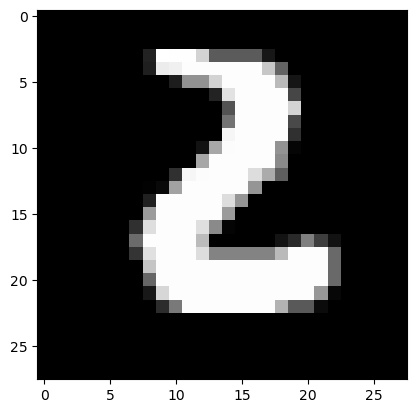

In [9]:
# This function tests the prediction for a specific index in the training dataset using the trained parameters W1, b1, W2, and b2. 
# It prints the prediction, actual label, and displays the corresponding image.

test_prediction(5, W1, b1, W2, b2)

Prediction:  [6]
Label:  6


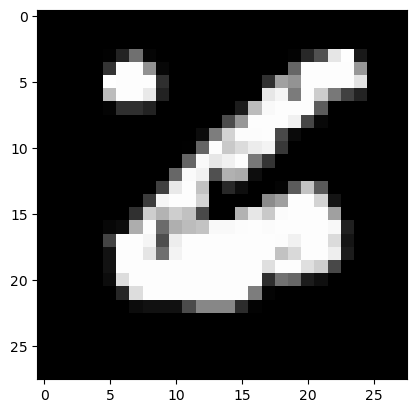

In [10]:
test_prediction(133, W1, b1, W2, b2)

In [11]:
# This code generates predictions for the development dataset and calculates the accuracy of these predictions compared to the actual labels.

dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

0.8374878048780487

In [12]:
# Now let's test the accuracy of our model code by running our NEW test data

data_new = pd.read_csv(r"C:\Users\Home\Documents\STUDIUM\mnist_test.csv")

In [13]:
data_new.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# I'm quickly inspecting my column names and checking the structure of this dataset to make sure it's euqal to my training data
print(data_new.columns)

Index(['label', '1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9',
       ...
       '28x19', '28x20', '28x21', '28x22', '28x23', '28x24', '28x25', '28x26',
       '28x27', '28x28'],
      dtype='object', length=785)


In [15]:
# We're preprocessing the new dataset in the same way as we did with the training and test datasets
# Followed by normalizing pixel values and reshaping features
# Making sure the preprocessing steps match what we did before

def preprocess_features(data):
    X = data.drop(columns=['label']).values  
    X = X / 255. 
    X = X.reshape(X.shape[0], -1)  
    return X



# Preparing the new dataset features for analysis
X_new = preprocess_features(data_new)


#  Extracts and preprocesses the labels from the dataset
def preprocess_labels(data):
    Y = data['label'].values 
    return Y


# Preprocesses the labels of the new dataset
Y_new = preprocess_labels(data_new)


# Now, using our existing code we run the Data through the Neural Network
# Knowing that we previously have defined functions like forward_prop and get_predictions
_, _, _, A2_new = forward_prop(W1, b1, W2, b2, X_new.T)
predictions_new = get_predictions(A2_new)


# Last Step: Evaluating the Accuracy
# We compare the predictions with the true labels to calculate the accuracy.
accuracy_new = get_accuracy(predictions_new, Y_new)
print("Accuracy on New Dataset:", accuracy_new)

Accuracy on New Dataset: 0.8475
